In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load data
df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Data/top40_cell_cycle.csv")

# Combine phase M and G2 into one class
df['phase'] = df['phase'].replace({'M': 'G2'})

le = LabelEncoder()
df['phase'] = le.fit_transform(df['phase']) 

# Separate features and target
X = df.drop(columns=['phase', 'age'])
y = df['phase']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=949, stratify=y)

In [3]:
# Initialize XGBoost Regressor
xgb_model = XGBClassifier(
    n_estimators=500,
    eta = 0.1,
    max_depth=3,
    tree_method = "hist",
    random_state=949
)

In [6]:
## hypertuning

param_grid = {
    'n_estimators': [500],              
    'max_depth': [20, 30, 40],
    'eta': [0.05]          
}

# Set up GridSearch with 10-fold cross-validation optimizing for accuracy
grid_search = GridSearchCV(
    estimator= xgb_model,
    param_grid=param_grid,
    cv=10,
    scoring= 'accuracy',
    n_jobs=-1
)

# Fit the model to your data
grid_search.fit(X_train, y_train)

#Output best settings and best accuracy
print("Best parameters:", grid_search.best_params_)
#print("Best cross-validation accuracy:", grid_search.best_score_)

Best parameters: {'eta': 0.05, 'max_depth': 20, 'n_estimators': 500}


In [3]:
# retrain model
xgb_model = XGBClassifier(
    n_estimators=500,
    eta = 0.05,
    max_depth=20,
    tree_method = "hist",
    random_state=949
)

In [4]:
xgb_model.fit(X_train, y_train)

# Predict
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [9]:
y_train_labels = le.inverse_transform(y_train)
y_test_labels = le.inverse_transform(y_test)
y_train_pred_labels = le.inverse_transform(y_train_pred)
y_test_pred_labels = le.inverse_transform(y_test_pred)

# Output results
print("=== Training Set ===")
print("Overall Accuracy:", accuracy_score(y_train_labels, y_train_pred_labels))

print("\n=== Test Set ===")
print("Overall Accuracy:", accuracy_score(y_test_labels, y_test_pred_labels))

# Accuracy per phase (Train)
df_train = pd.DataFrame({'true': y_train_labels, 'pred': y_train_pred_labels})
accuracy_per_phase_train = df_train.groupby('true').apply(lambda x: accuracy_score(x['true'], x['pred']))

print("Accuracy per phase (Train):")
print(accuracy_per_phase_train)

# Accuracy per phase (Test)
df_test = pd.DataFrame({'true': y_test_labels, 'pred': y_test_pred_labels})
accuracy_per_phase_test = df_test.groupby('true').apply(lambda x: accuracy_score(x['true'], x['pred']))

print("\nAccuracy per phase (Test):")
print(accuracy_per_phase_test)

# Confusion Matrix
print("\nTest Confusion Matrix")
print(confusion_matrix(y_test_labels, y_test_pred_labels, labels=["G0", "G1", "G2", "S"]))

=== Training Set ===
Overall Accuracy: 1.0

=== Test Set ===
Overall Accuracy: 0.9717514124293786
Accuracy per phase (Train):
true
G0    1.0
G1    1.0
G2    1.0
S     1.0
dtype: float64

Accuracy per phase (Test):
true
G0    0.975871
G1    0.970032
G2    0.962185
S     0.975238
dtype: float64

Test Confusion Matrix
[[364   7   2   0]
 [  2 615   3  14]
 [  0   0 229   9]
 [  0   6   7 512]]


/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_72767/4154681254.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_phase_train = df_train.groupby('true').apply(lambda x: accuracy_score(x['true'], x['pred']))
/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_72767/4154681254.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_phase_test = df_test.groupby('true').apply(

                     MDI Importance
Feature                            
pRB..nuc.median.             6366.0
RB..nuc.median.              6216.0
p21..nuc.median.             3239.0
E2F1..nuc.median.            2395.0
cycA..nuc.median.            2346.0
PCNA..nuc.median.            2001.0
Int_Intg_DNA_nuc             1804.0
Cdt1..nuc.median.            1601.0
cycD1..nuc.median.           1542.0
pH2AX..nuc.median.           1456.0
Skp2..nuc.median.            1440.0
Cdh1..nuc.median.            1295.0
pp21..nuc.median.            1271.0
cycD1..cyto.median.          1245.0
Nuc.area                     1192.0
cMyc..nuc.median.            1026.0
Cell.area                    1025.0
S6..nuc.median.               969.0
Skp2..cell.median.            953.0
CDK6..nuc.median.             944.0
ERK..nuc.median.              919.0
cycE..nuc.median.             913.0
GSK3b..nuc.median.            861.0
p27..nuc.median.              829.0
CDK2..cyto.median.            794.0
CDK4..nuc.median.           

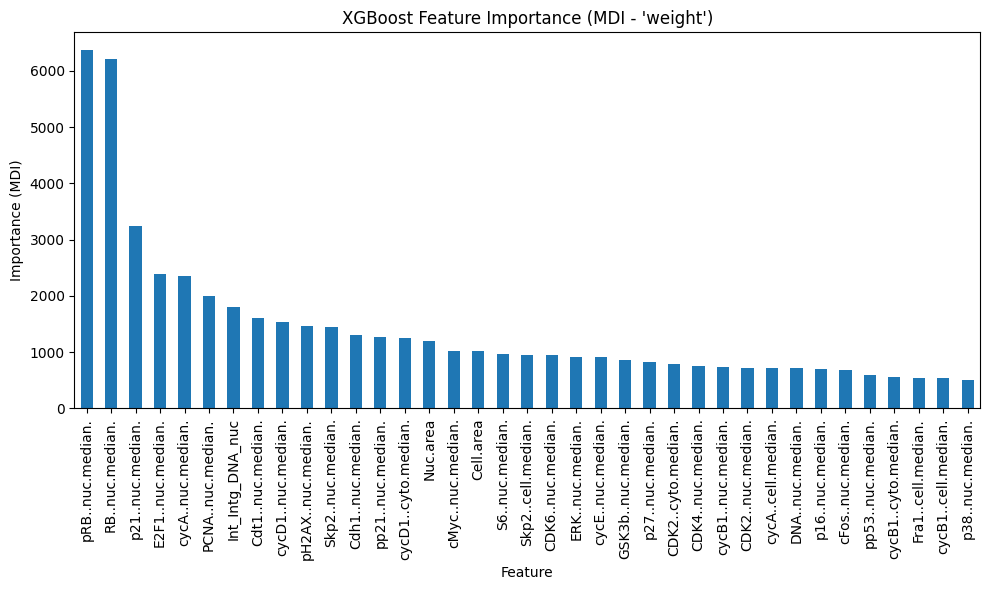

In [ ]:
# MDI feature ranking (weight)
booster = xgb_model.get_booster()

# Get importance by "weight" (~ MDI)
importance_dict = booster.get_score(importance_type='weight')

# Convert to DataFrame
importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['MDI Importance'])
importance_df.index.name = 'Feature'
importance_df = importance_df.sort_values(by='MDI Importance', ascending=False)

# Display
print(importance_df)

# Optional: Plot
importance_df.plot(kind='bar', figsize=(10, 6), legend=False)
plt.title("XGBoost Feature Importance (MDI - 'weight')")
plt.ylabel("Importance (MDI)")
plt.tight_layout()
plt.show()